In [ ]:
!pip install segmentation-models-pytorch
!pip install torchtext
!pip install pytorch-lightning
# !pip install git+https://github.com/PyTorchLightning/pytorch-lightning
# !pip install --upgrade pytorch-lightning
# import pytorch_lightning as pl
# print(pl.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [ ]:
# from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
# root = "."
# SimpleOxfordPetDataset.download(root)

In [ ]:
import os
import random
import shutil
from google.colab import drive
drive.mount('/content/drive')

# Define paths
train_images_path = "/content/drive/My Drive/Dissertation Code/pianoDetectData/train/images"
train_masks_path = "/content/drive/My Drive/Dissertation Code/pianoDetectData/train/masks"
valid_images_path = "/content/drive/My Drive/Dissertation Code/pianoDetectData/valid/images"
valid_masks_path = "/content/drive/My Drive/Dissertation Code/pianoDetectData/valid/masks"
test_images_path = "/content/drive/My Drive/Dissertation Code/pianoDetectData/test/images"
test_masks_path = "/content/drive/My Drive/Dissertation Code/pianoDetectData/test/masks"

# Continue data pre-processing
def move_files_to_test_set(images_path, masks_path, test_images_path, test_masks_path, test_ratio=1/3):
    if os.listdir(test_images_path) or os.listdir(test_masks_path):
      print("Test files exist.")
      return
    os.makedirs(test_images_path, exist_ok=True)
    os.makedirs(test_masks_path, exist_ok=True)

    image_files = os.listdir(images_path)
    mask_files = set(os.listdir(masks_path))

    # Filter to find matching pairs
    matched_files = [file for file in image_files if os.path.splitext(file)[0] + ".png" in mask_files]

    # Select a random subset
    random.shuffle(matched_files)
    num_test_files = int(len(matched_files) * test_ratio)
    test_files = matched_files[:num_test_files]

    # Move the image and mask files to test set
    for filename in test_files:
        # Corresponding name
        mask_filename = os.path.splitext(filename)[0] + ".png"

        image_src = os.path.join(images_path, filename)
        mask_src = os.path.join(masks_path, mask_filename)
        image_dest = os.path.join(test_images_path, filename)
        mask_dest = os.path.join(test_masks_path, mask_filename)

        # Move files
        shutil.move(image_src, image_dest)
        shutil.move(mask_src, mask_dest)
        print(f"Moved {filename} to {test_images_path}")
        print(f"Moved {mask_filename} to {test_masks_path}")

move_files_to_test_set(valid_images_path, valid_masks_path, test_images_path, test_masks_path)

Mounted at /content/drive
Test files exist.


In [ ]:
import cv2
import numpy as np
import torch

# More pre-processing
def process_images(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Ensure the image dimension is correct
    image = cv2.resize(image, (640, 384), interpolation=cv2.INTER_AREA)
    # Transpose the images
    image_transposed = np.transpose(image, (2, 0, 1))
    # Convert to torch tensor
    image_tensor = torch.tensor(image_transposed, dtype=torch.float32)
    return image_tensor

def process_mask_images(file_path):
    mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (640, 384), interpolation=cv2.INTER_NEAREST)
    # Expand to 1HW
    mask_expanded = np.expand_dims(mask, axis=0)
    mask_tensor = torch.tensor(mask_expanded, dtype=torch.long)
    return mask_tensor

def process_directory(directory, process_function, tensor_list):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            tensor = process_function(file_path)
            tensor_list.append(tensor)
            # print(filename, tensor.shape)

# Lists to store tensors
train_image_tensors = []
valid_image_tensors = []
test_image_tensors = []
train_mask_tensors = []
valid_mask_tensors = []
test_mask_tensors = []

# Process each directory
process_directory(train_images_path, process_images, train_image_tensors)
process_directory(valid_images_path, process_images, valid_image_tensors)
process_directory(test_images_path, process_images, test_image_tensors)
process_directory(train_masks_path, process_mask_images, train_mask_tensors)
process_directory(valid_masks_path, process_mask_images, valid_mask_tensors)
process_directory(test_masks_path, process_images, test_mask_tensors)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SimplePianoDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        """
        Initialize the dataset with the directory of images and masks.
        Args:
        images_dir (str): Path to the images directory.
        masks_dir (str): Path to the masks directory.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(file)[0] for file in os.listdir(images_dir)]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx] + '.jpg'  # Adjust the extension if your images differ
        mask_name = self.filenames[idx] + '.png'  # Adjust the extension if your masks differ

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Load mask as grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {'image': image, 'mask': mask}

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

def initialize_dataloaders():
    # Transformation for the dataset
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize all images to a common size
        transforms.ToTensor(),  # Convert images and masks to PyTorch tensors
    ])

    # Initialize datasets
    train_dataset = SimplePianoDataset(train_images_path, train_masks_path, transform=transform)
    valid_dataset = SimplePianoDataset(valid_images_path, valid_masks_path, transform=transform)
    test_dataset = SimplePianoDataset(test_images_path, test_masks_path, transform=transform)

    # Setup DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    return train_dataloader, valid_dataloader, test_dataloader, train_dataset, valid_dataset, test_dataset

if __name__ == '__main__':
    train_dataloader, valid_dataloader, test_dataloader, train_dataset, valid_dataset, test_dataset = initialize_dataloaders()

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(batch):
    image = batch['image'][0]
    mask = batch['mask'][0]

    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    # Convert image from (C, H, W) to (H, W, C)
    if image.dim() == 3 and image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # If the mask is in (1, H, W), squeeze it to (H, W)
    if mask.dim() == 3:
        mask = mask.squeeze(0)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

if __name__ == '__main__':
    train_loader, _, _, _, _, _ = initialize_dataloaders()
    batch = next(iter(train_loader))
    visualize_sample(batch)


ValueError: too many values to unpack (expected 3)

In [ ]:
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

# n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Training Sample:
Sample keys: dict_keys(['image', 'mask'])
image shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])


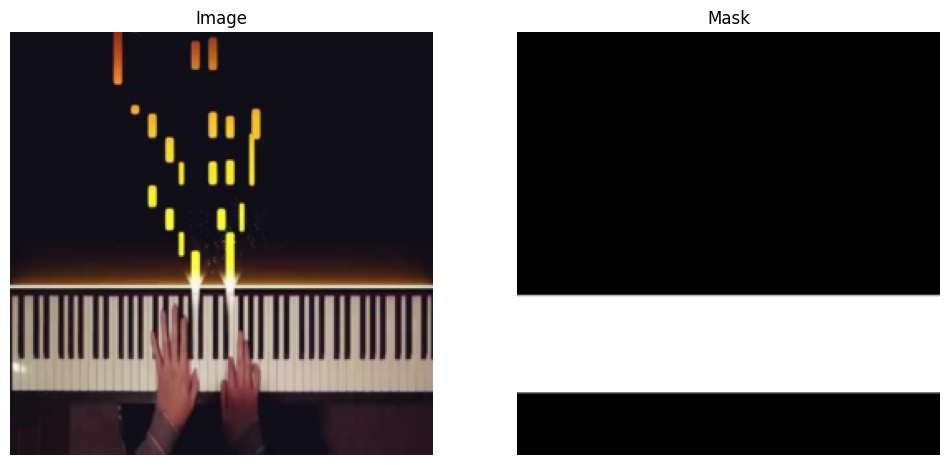

Validation Sample:
Sample keys: dict_keys(['image', 'mask'])
image shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])


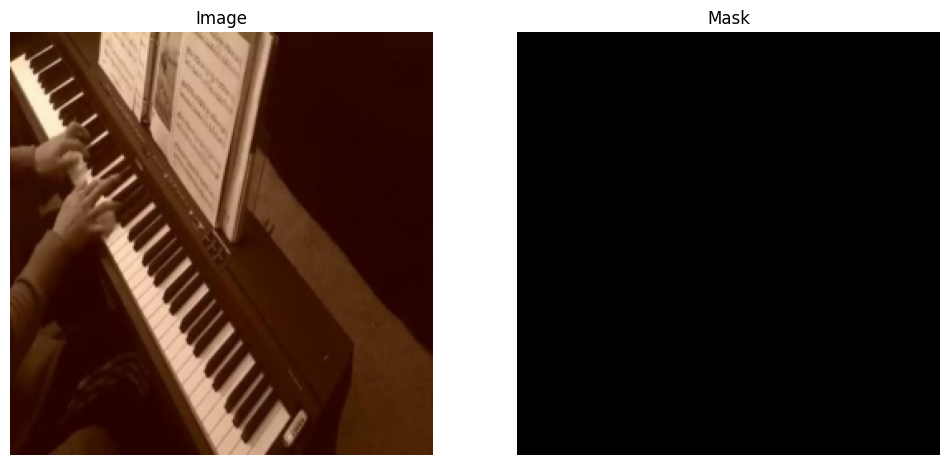

Test Sample:
Sample keys: dict_keys(['image', 'mask'])
image shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])


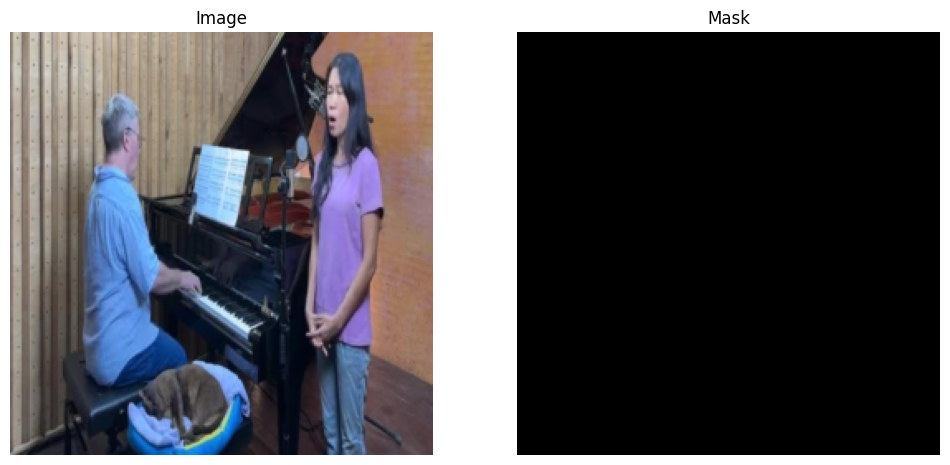

In [ ]:
=import matplotlib.pyplot as plt

def visualize_sample(sample):
    print("Sample keys:", sample.keys())

    for key, value in sample.items():
        if hasattr(value, 'shape'):
            print(f"{key} shape: {value.shape}")
        else:
            print(f"{key} content: {value}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    image = sample['image']
    if image.dim() == 3 and image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    mask = sample['mask']
    if mask.dim() == 3:
        mask = mask.squeeze(0)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

if __name__ == '__main__':
    sample_train = train_dataset[0]
    sample_valid = valid_dataset[0]
    sample_test = test_dataset[0]

    print("Training Sample:")
    visualize_sample(sample_train)

    print("Validation Sample:")
    visualize_sample(sample_valid)

    print("Test Sample:")
    visualize_sample(sample_test)


## Model

In [ ]:
class KeyboardSegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch["image"], batch["mask"]
        logits_mask = self(image)
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        self.log(f"{stage}_loss", loss)
        self.log(f"{stage}_iou", iou, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self.shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        self.shared_step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

    # def shared_step(self, batch, stage):

    #     image = batch["image"]

    #     # Shape of the image should be (batch_size, num_channels, height, width)
    #     # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
    #     assert image.ndim == 4

    #     # Check that image dimensions are divisible by 32,
    #     # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
    #     # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
    #     # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
    #     # and we will get an error trying to concat these features
    #     h, w = image.shape[2:]
    #     assert h % 32 == 0 and w % 32 == 0

    #     mask = batch["mask"]

    #     # Shape of the mask should be [batch_size, num_classes, height, width]
    #     # for binary segmentation num_classes = 1
    #     assert mask.ndim == 4

    #     # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
    #     assert mask.max() <= 1.0 and mask.min() >= 0

    #     logits_mask = self.forward(image)

    #     # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
    #     loss = self.loss_fn(logits_mask, mask)

    #     # Lets compute metrics for some threshold
    #     # first convert mask values to probabilities, then
    #     # apply thresholding
    #     prob_mask = logits_mask.sigmoid()
    #     pred_mask = (prob_mask > 0.5).float()

    #     # We will compute IoU metric by two ways
    #     #   1. dataset-wise
    #     #   2. image-wise
    #     # but for now we just compute true positive, false positive, false negative and
    #     # true negative 'pixels' for each image and class
    #     # these values will be aggregated in the end of an epoch
    #     tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

    #     return {
    #         "loss": loss,
    #         "tp": tp,
    #         "fp": fp,
    #         "fn": fn,
    #         "tn": tn,
    #     }

    # def shared_epoch_end(self, outputs, stage):
    #     # aggregate step metics
    #     tp = torch.cat([x["tp"] for x in outputs])
    #     fp = torch.cat([x["fp"] for x in outputs])
    #     fn = torch.cat([x["fn"] for x in outputs])
    #     tn = torch.cat([x["tn"] for x in outputs])

    #     # per image IoU means that we first calculate IoU score for each image
    #     # and then compute mean over these scores
    #     per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

    #     # dataset IoU means that we aggregate intersection and union over whole dataset
    #     # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
    #     # in this particular case will not be much, however for dataset
    #     # with "empty" images (images without target class) a large gap could be observed.
    #     # Empty images influence a lot on per_image_iou and much less on dataset_iou.
    #     dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

    #     metrics = {
    #         f"{stage}_per_image_iou": per_image_iou,
    #         f"{stage}_dataset_iou": dataset_iou,
    #     }

    #     self.log_dict(metrics, prog_bar=True)

    # def training_step(self, batch, batch_idx):
    #     return self.shared_step(batch, "train")

    # def training_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "train")

    # def validation_step(self, batch, batch_idx):
    #     return self.shared_step(batch, "valid")

    # def validation_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "valid")

    # def test_step(self, batch, batch_idx):
    #     return self.shared_step(batch, "test")

    # def test_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "test")

    # def configure_optimizers(self):
    #     return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = KeyboardSegmentationModel("FPN", "resnet50", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


## Training

In [ ]:
trainer = pl.Trainer(
    # gpus=1,
    accelerator="auto",
    max_epochs=5,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 26.1 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.464   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_iou': 0.8527823090553284, 'valid_loss': 0.08022993803024292}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_iou': 0.863813042640686, 'test_loss': 0.07605870813131332}]


# Result visualization

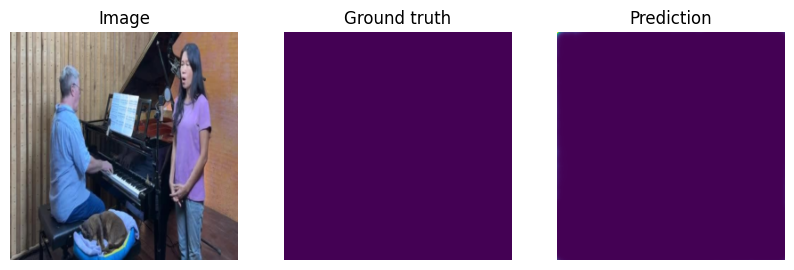

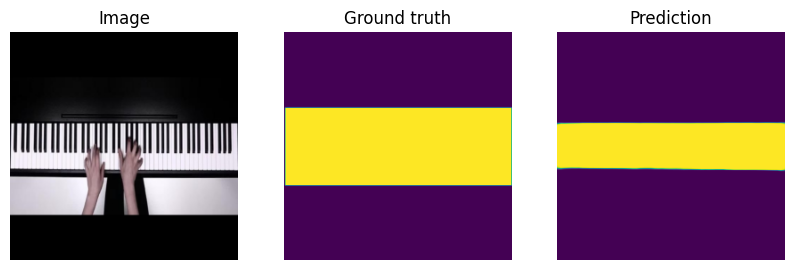

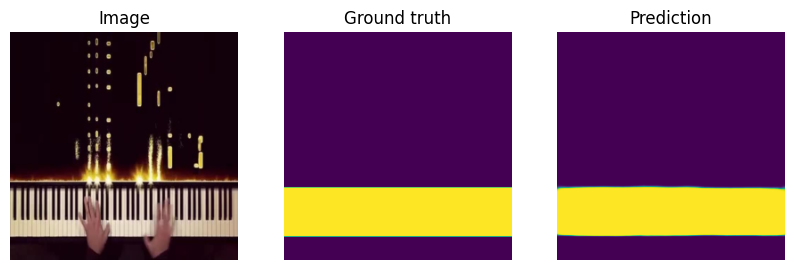

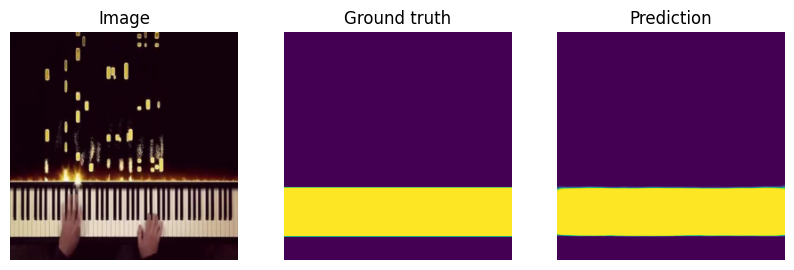

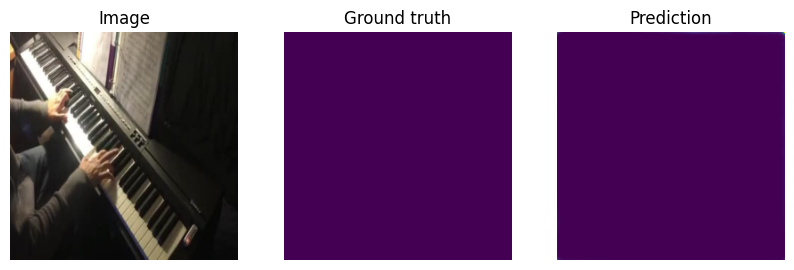

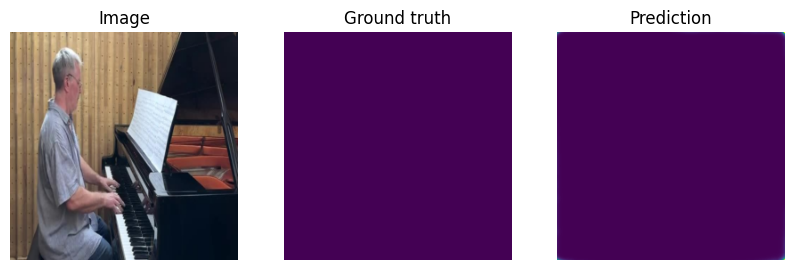

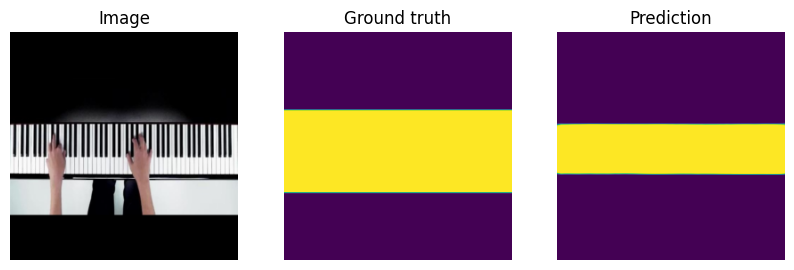

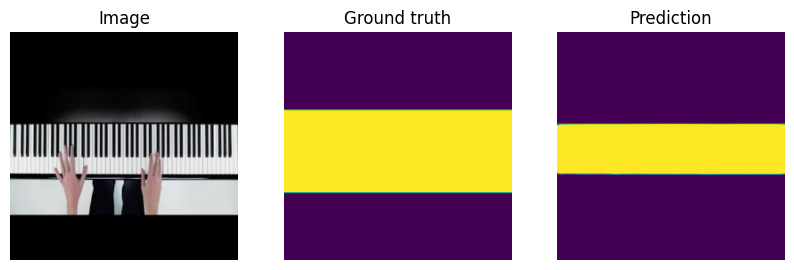

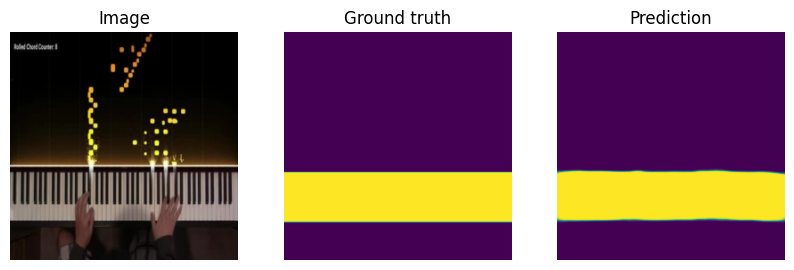

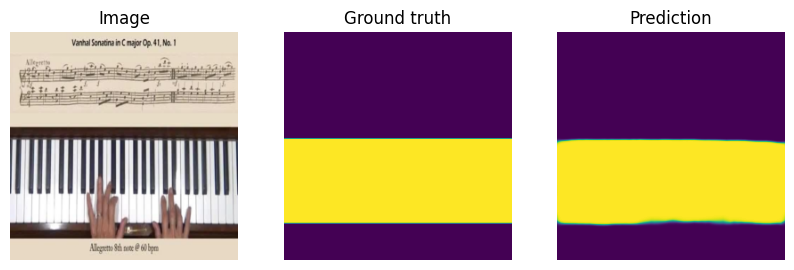

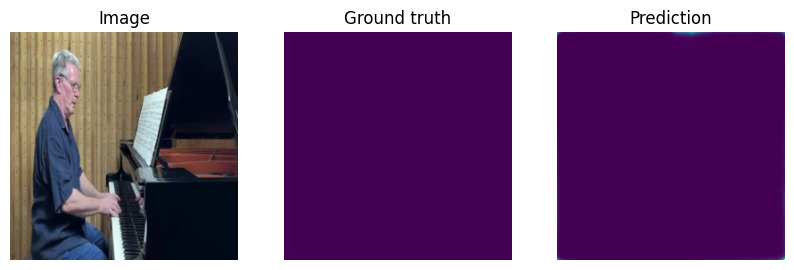

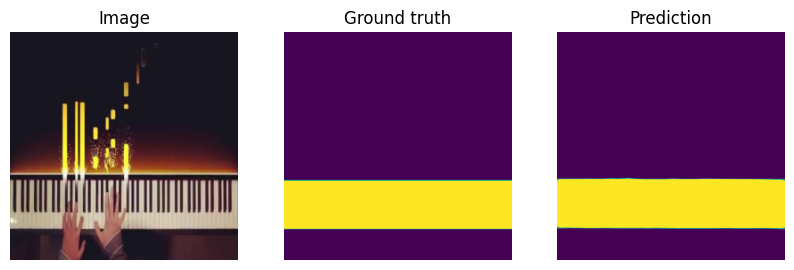

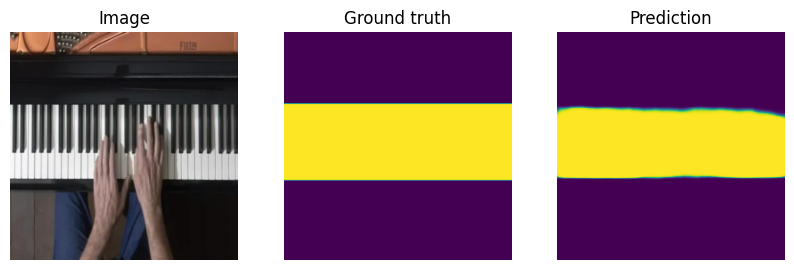

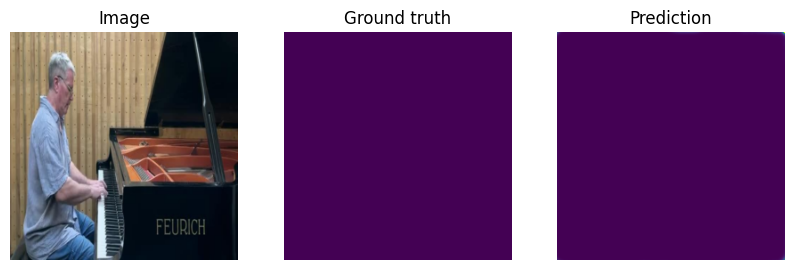

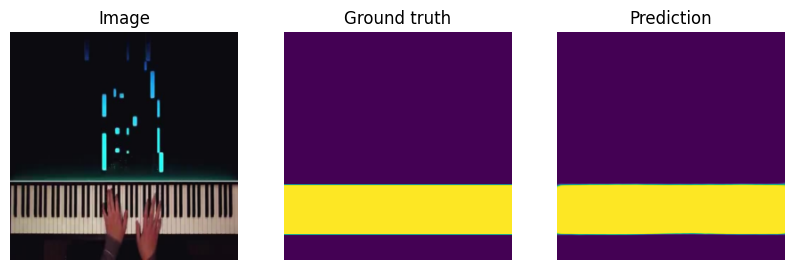

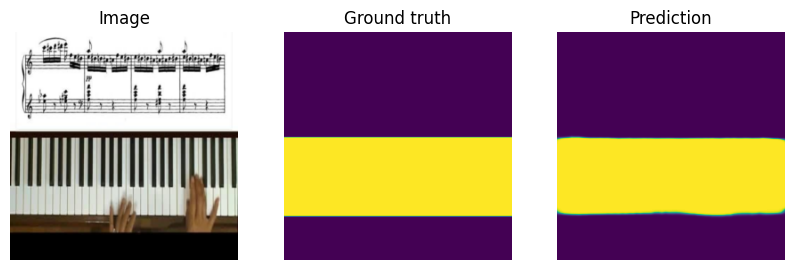

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [ ]:
# Save the model and simply the state dictionary
torch.save(model, 'keyboardSegmentation.pth')
torch.save(model.state_dict(), 'keyboardSegmentation_state_dict.pth')

In [ ]:
from google.colab import files
files.download('keyboardSegmentation.pth')
files.download('keyboardSegmentation_state_dict.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

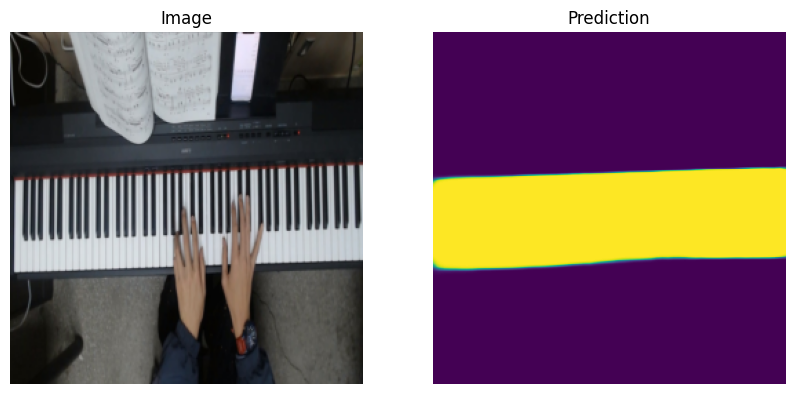

In [ ]:
test_image = "/content/drive/My Drive/Dissertation Code/pianoDetectData/test.jpg"
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
image = Image.open(test_image)
image = transform(image).unsqueeze(0)

model.eval()
with torch.no_grad():
    logits = model(image)
    pr_mask = logits.sigmoid()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image[0].numpy().transpose(1, 2, 0))
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pr_mask[0].numpy().squeeze())
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

In [ ]:
# Print every first frame from the OMAPS dataset

In [ ]:
image_directory = #

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def process_and_predict(image_path, model, transform):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        logits = model(image_tensor)
        pr_mask = logits.sigmoid()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor[0].numpy().transpose(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pr_mask[0].numpy().squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

for filename in os.listdir(image_directory):
    file_path = os.path.join(image_directory, filename)
    if os.path.isfile(file_path):
        print(f"Processing and predicting for {filename}")
        process_and_predict(file_path, model, transform)